In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-tracking-germany/de_state.shp
/kaggle/input/covid19-tracking-germany/de_county.prj
/kaggle/input/covid19-tracking-germany/de_state.dbf
/kaggle/input/covid19-tracking-germany/de_state.cpg
/kaggle/input/covid19-tracking-germany/covid_de.csv
/kaggle/input/covid19-tracking-germany/de_county.cpg
/kaggle/input/covid19-tracking-germany/de_state.shx
/kaggle/input/covid19-tracking-germany/demographics_de.csv
/kaggle/input/covid19-tracking-germany/de_county.dbf
/kaggle/input/covid19-tracking-germany/de_county.shx
/kaggle/input/covid19-tracking-germany/de_state.prj
/kaggle/input/covid19-tracking-germany/covid_de_vaccines.csv
/kaggle/input/covid19-tracking-germany/de_county.shp


# **Dataset**

In [2]:
#Importing
covid = pd.read_csv('/kaggle/input/covid19-tracking-germany/covid_de.csv')
covid['date'] = pd.to_datetime(covid['date'])
demographics = pd.read_csv('/kaggle/input/covid19-tracking-germany/demographics_de.csv')
covid.head()

,state,county,age_group,gender,date,cases,deaths,recovered
0,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-27,1,0,1
1,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-03-28,1,0,1
2,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-04-03,1,0,1
3,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-18,1,0,1
4,Baden-Wuerttemberg,LK Alb-Donau-Kreis,00-04,F,2020-10-22,1,0,1


In [3]:
print('Shape (num_rows, num_columns): ', covid.shape)
print('\n')
print('The date range of the data is: ', covid.date.min().strftime('%d.%m.%Y'), '-', covid.date.max().strftime('%d.%m.%Y'))
print('\n')
print('Info:')
covid.info()

Shape (num_rows, num_columns):  (782515, 8)


The date range of the data is:  07.01.2020 - 02.05.2021


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782515 entries, 0 to 782514
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   state      782515 non-null  object        
 1   county     782515 non-null  object        
 2   age_group  780064 non-null  object        
 3   gender     765802 non-null  object        
 4   date       782515 non-null  datetime64[ns]
 5   cases      782515 non-null  int64         
 6   deaths     782515 non-null  int64         
 7   recovered  782515 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 47.8+ MB


In [4]:
print('Columns having missing values:')
missing = covid.isnull().sum()
print(missing[missing > 0])

Columns having missing values:
age_group     2451
gender       16713
dtype: int64


In [5]:
#fill missing age_group with the most frequent value
freq_age = covid.age_group.value_counts().idxmax()
print('Most frequent age group: ', freq_age)
covid.age_group.fillna(freq_age, inplace=True)

#for gender missing values, fill half with 'M' and half with 'F'
mask = covid.gender.isna() 
ind = covid.gender.loc[mask].sample(frac=0.5).index
covid.loc[ind, 'gender'] = 'M'
covid.gender.fillna('F', inplace=True)

Most frequent age group:  35-59


In [6]:
#Demographics
demographics.head()

,state,gender,age_group,population
0,Baden-Wuerttemberg,female,00-04,261674
1,Baden-Wuerttemberg,female,05-14,490822
2,Baden-Wuerttemberg,female,15-34,1293488
3,Baden-Wuerttemberg,female,35-59,1919649
4,Baden-Wuerttemberg,female,60-79,1182736


# **Data Analysis**

In [7]:
covid_bydate = covid.groupby('date').sum()
print(covid_bydate)

            cases  deaths  recovered
date                                
2020-01-07      1       0          1
2020-01-19      1       0          1
2020-01-23      1       0          1
2020-01-25      1       0          1
2020-01-28      2       0          2
...           ...     ...        ...
2021-04-28  24978      16        496
2021-04-29  21322      15        310
2021-04-30  18687      12        184
2021-05-01  14380       4         85
2021-05-02   5298       1         30

[451 rows x 3 columns]


**Number of people infected over time**

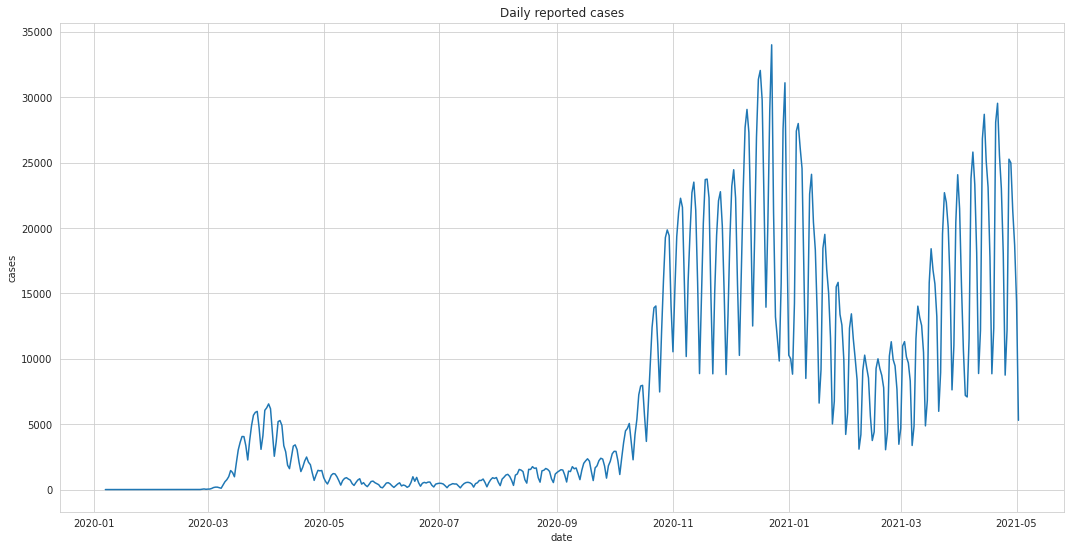

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_style("whitegrid")
plt.figure(figsize=(18,9))
plt.title('Daily reported cases')
p=sns.lineplot(data=covid_bydate['cases'])

* It seems the number of infected cases by day reached its peak near the start of 2021. 
* In addition, a second wave of infections is visible too near May 2021.

**Number of deaths over time**

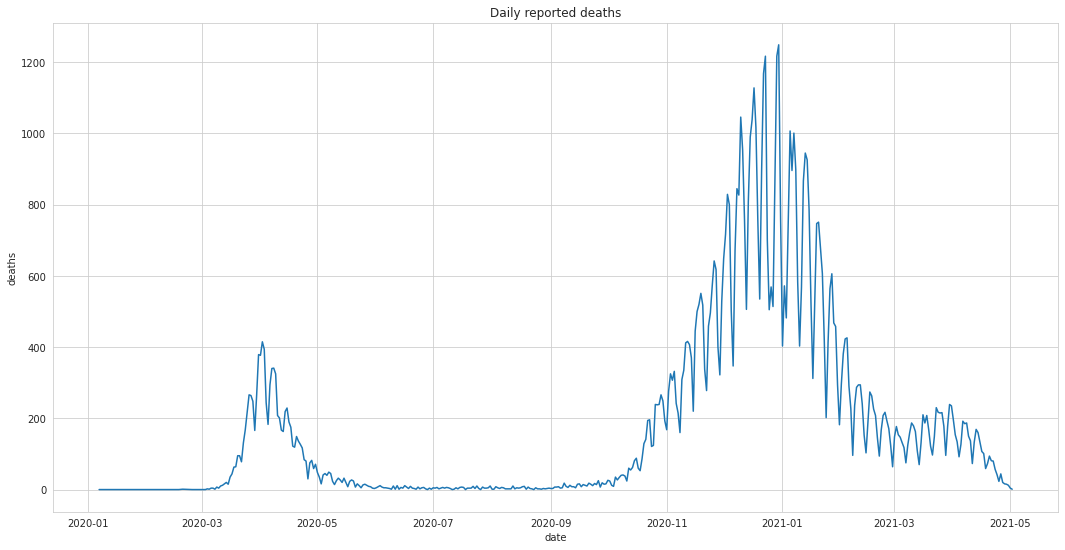

In [9]:
plt.figure(figsize=(18,9))
plt.title('Daily reported deaths')
p=sns.lineplot(data=covid_bydate['deaths'])

* From the graph, it is visible that the high number of deaths were reported around April 2020, and with time, the death rate decreased.
* Unfortunately, again, the highest number of deaths, far more than in 2020, were reported in early 2021.

**Infection Distribution over Age Groups**

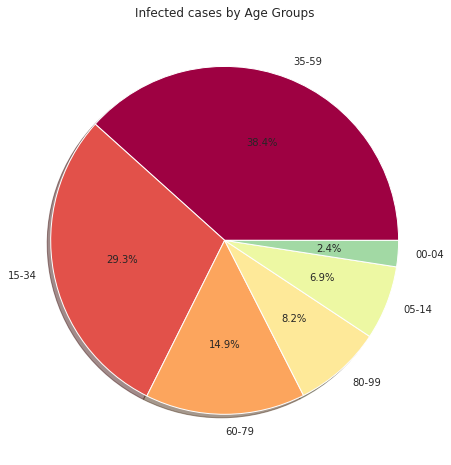

In [10]:
covid_byage = covid.groupby('age_group').sum()
covid_byage.sort_values('cases', ascending=False, inplace=True)
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

plt.figure(figsize=(8,8))
plt.pie(covid_byage.cases, labels=covid_byage.index, autopct='%1.1f%%', shadow=True, colors=colors)
plt.title("Infected cases by Age Groups")
plt.show()

* Adults and Middle-age people were mostly affected by the disease.
* Let's see if the death ratio is following the same distribution.

**Death Ratio by Age Group**\
For each age group, how many percentage of people, infected by the virus, died.


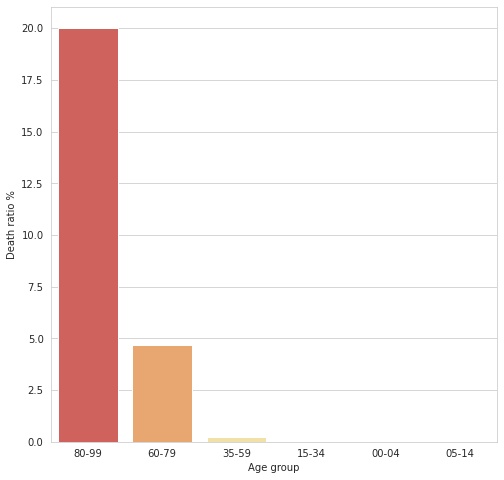

In [11]:
deaths_ratio = covid_byage.deaths / covid_byage.cases * 100.0
covid_byage['death_ratio'] = deaths_ratio
covid_byage.sort_values('death_ratio', ascending=False, inplace=True)

plt.figure(figsize=(8,8))
death_pie = sns.barplot(y=covid_byage.death_ratio, x=covid_byage.index, palette='Spectral')
p=plt.xlabel('Age group')
p=plt.ylabel('Death ratio %')

* Even though the people in age groups 15-34 and 25-59 were the most infected, the people in old age, 80-99, were more likely to die.
* Almost 20% people who got infected at age above 80 died from the disease.
* Death fatalities were far less in people below 60 years.

**Infection Distribution by Gender**

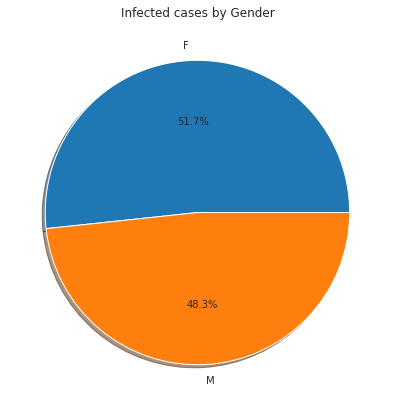

In [12]:
covid_bygender = covid.groupby('gender').sum()
covid_bygender.sort_values('cases', ascending=False, inplace=True)

plt.figure(figsize=(7,7))
plt.pie(covid_bygender.cases, labels=covid_bygender.index, shadow=True, autopct='%1.1f%%')
plt.title("Infected cases by Gender")
plt.show()

* Almost equal number of males and females were affected by the virus.
* Hence, there seems no pattern in infection between gender.

**Death Ratio by Gender**

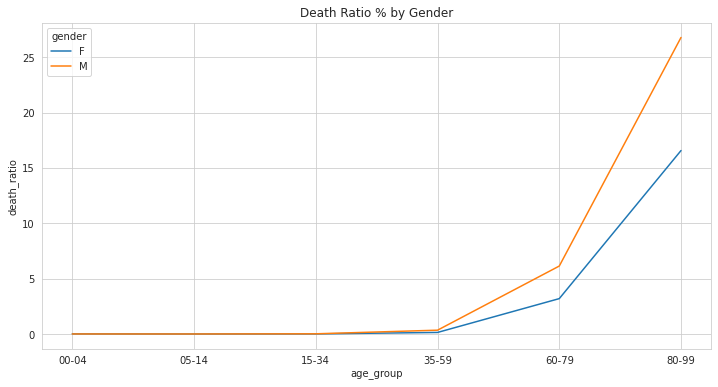

In [13]:
covid_ag = covid.groupby(by=["age_group", "gender"]).sum()
covid_ag["death_ratio"] = 100 * covid_ag["deaths"] / covid_ag["cases"]
plt.figure(figsize=(12,6))
sns.lineplot(data=covid_ag, x="age_group", y="death_ratio", hue="gender")
plt.title("Death Ratio % by Gender")
plt.show()

* It shows that males who were infected were more likely to die than infected females.
* Although, this pattern occured only for people above 35 years.

**Distribution over Federal States**

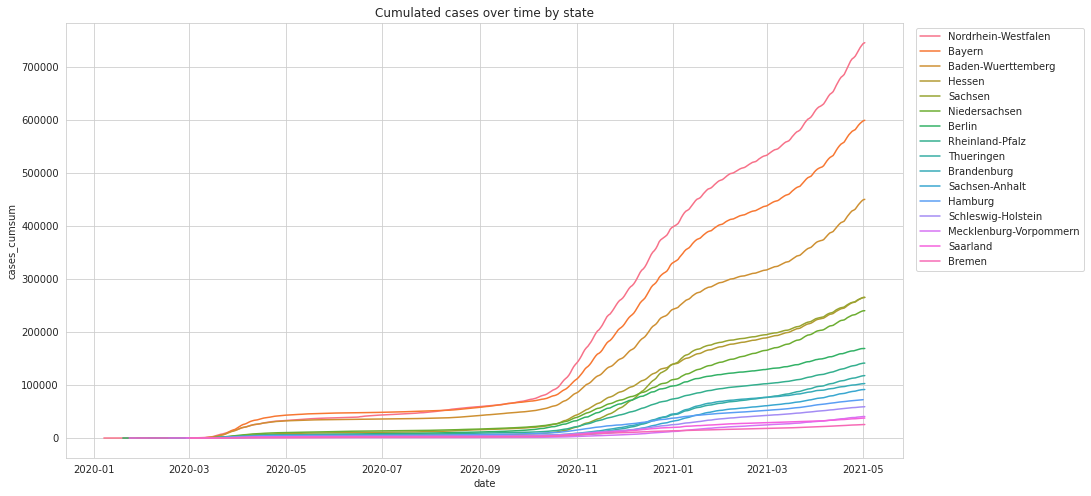

In [14]:
df_state = covid.groupby(by=["state", "date"]).sum()
df_state = df_state.replace([np.inf, -np.inf], 0)
df_state["cases_cumsum"] = df_state.groupby(level=-2)["cases"].cumsum()
df_state = df_state.reset_index()

plt.figure(figsize=(15,8))
ln = sns.lineplot(data=df_state.sort_values("cases_cumsum", ascending=False), x="date", y="cases_cumsum", hue="state")
ln.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.title("Cumulated cases over time by state")
plt.show()

* The states with most number of cases were: Nordrhein Wesfalen, Bayern, and Baden Wurttemberg.
* But let's see if the infection rates currently in states are same as the rate during peak time.

[]

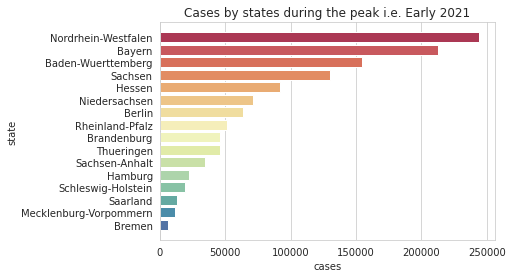

In [15]:
mask = (covid['date'] > '2020-11-15') & (covid['date'] <= '2021-1-15')
covid_peak = covid.loc[mask]
covid_by_state_peak = covid_peak.groupby('state').sum()
covid_by_state_peak.sort_values('cases', ascending=False, inplace=True)
sns.barplot(x=covid_by_state_peak.cases, y=covid_by_state_peak.index, palette='Spectral')
plt.title("Cases by states during the peak i.e. Early 2021")
plt.plot()

* As seen from the graph, the top states were still same during the peak time i.e. Dec 2020 - Jan 2021.

**Comparing plain numbers like this might be misleading, since every states have different size and population, and bigger states might have more number of cases. Hence, it is more appropriate to compare the ratio of cases to the population of each state. (Infection Density)**

In [16]:
states_population = demographics.groupby('state').sum().sort_values('population', ascending=False)
states_population

,population
state,
Nordrhein-Westfalen,17932651
Bayern,13076721
Baden-Wuerttemberg,11069533
Niedersachsen,7982448
Hessen,6265809
Rheinland-Pfalz,4084844
Sachsen,4077937
Berlin,3644826
Schleswig-Holstein,2896712


[]

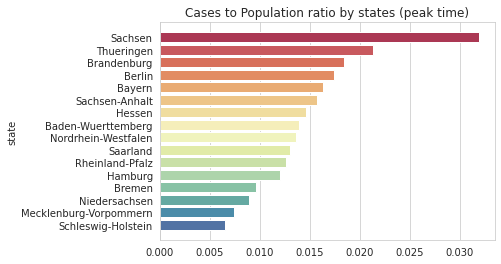

In [17]:
covid_peak_ratio = covid_by_state_peak.cases / states_population.loc[covid_by_state_peak.index].population
covid_peak_ratio.sort_values(ascending=False, inplace=True)
sns.barplot(x=covid_peak_ratio, y=covid_peak_ratio.index, palette='Spectral')
plt.title("Cases to Population ratio by states (peak time)")
plt.plot()

Now, we see a complete different story. We see that some small states that were in the tail of the previous plot (number of cases) are now at the top of the current plot (meaning that they have a larger ratio of infections to their population). Sachsen, which was in 4th place in total cases at peak graph, now seems the most densely infected state, having higest cases to population ratio during peak time. Also, Nordrhein Wesfalen, which was having the highest number of cases during the peak time, comes below in the cases to population ratio graph, because of its large population.

**Plotting on Map**

In [18]:
import geopandas as gpd
demographics["state"] = demographics["state"].replace("Baden-Wuerttemberg", "Baden-Württemberg")
demographics["state"] = demographics["state"].replace("Thueringen", "Thüringen")
demographics["gender"] = np.where(demographics["gender"] == "female", "F", "M")

df_map = gpd.read_file("../input/covid19-tracking-germany/de_state.shp")
df_map = df_map.drop(columns=["ADE", "RS", "RS_0"])

df_map_county = gpd.read_file("../input/covid19-tracking-germany/de_county.shp")

state_cov = covid.groupby(by="state", as_index=False).sum()
state_dem = demographics[["state", "population"]].groupby(by="state", as_index=False).sum()
df_state = df_map.merge(state_cov, how="left", left_on="GEN", right_on="state")
df_state = df_state.merge(state_dem, how="left", left_on="GEN", right_on="state")
df_state.drop(columns=["state_x", "state_y"], inplace=True)

df_state["case_ratio"] = df_state["cases"] * (1000 / df_state["population"])
df_state.set_index("GEN", inplace=True)

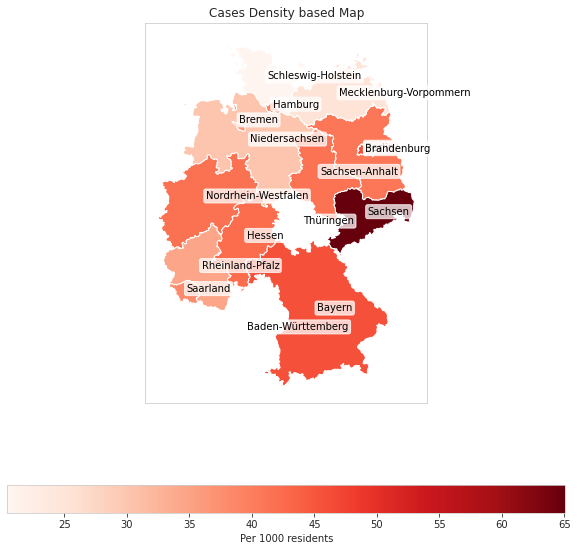

In [19]:
df_state.plot(column="case_ratio", legend=True,
                    legend_kwds={"label": "Per 1000 residents",
                                 "orientation": "horizontal"}, cmap="Reds",figsize=(10, 10))
for i, geo in df_state.centroid.iteritems():
    plt.annotate(text=i, xy=[geo.x, geo.y], color="black",
         bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.75))
plt.xticks([])
plt.yticks([])
plt.title("Cases Density based Map")
plt.show()

This map shows how many infection cases were reported per 1000 people in each state. Hence, shows the case density in the coutry.\
Sachen, displayed more dense, is a small state having large number of covid cases, hence higher density, as compared to others.